### Notebook for testing model
Setup: follow instructions on [author's github](https://github.com/Beckschen/TransUNet)

Extract dataset's `Image` folder to root dir of this repo.

In [130]:
from PIL import Image, ImageOps 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
import json

# Update max pixel to get rid of DecompressionBombError when reading img
Image.MAX_IMAGE_PIXELS = 933120000

# Test image
TEST_IMAGE_PATH = './images/train/2f6ecfcdf.tiff'
TEST_LABEL_PATH = './images/train/2f6ecfcdf.json'

# Import image and convert to grayscale
kidney_im = Image.open(TEST_IMAGE_PATH)
kidney_gray_im = ImageOps.grayscale(kidney_im) 

In [131]:
# Convert to numpy array
kidney_array = np.asarray(kidney_gray_im, dtype=np.float32)

### Plot test sample

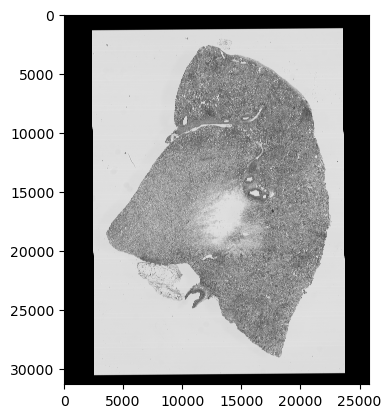

In [132]:
# Plot kidney image
imgplot = plt.imshow(kidney_array, cmap='gray')

### Plotting test sample + Mask

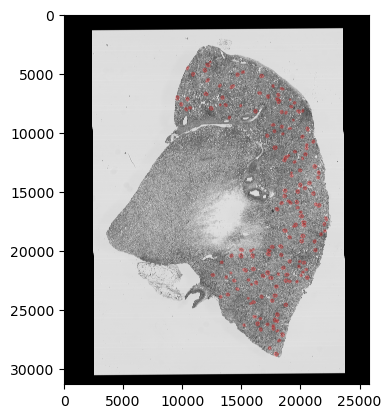

In [133]:
# Load label path from json file
kidney_label = json.load(open(TEST_LABEL_PATH))
for element in kidney_label:
    if element['type'] == 'Feature' and element['id'] == 'PathAnnotationObject':
        label = element['geometry']
        if label['type'] == 'Polygon':
            coordinates = label['coordinates'][0]
            
            # Create polygon from label coordinates and plot
            label_polygon = Polygon(coordinates, closed=True, color='red', alpha=0.2)
            ax = plt.gca()
            ax.add_patch(label_polygon)
            
imgplot = plt.imshow(kidney_array, cmap='gray')

### Test running the model with pretrained weights from the paper's author

In [134]:
# For reloading imports when editing .py files
%load_ext autoreload
%autoreload 2

# Change to networks.linux.vit_seg_modeling if running in linux env
from networks.windows.vit_seg_modeling import VisionTransformer as ViT_seg
from networks.windows.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
import torch

# Func for gettting models with different configs for quickly testing
def run_vit_model(model_name, model_path, n_classes, n_skip, patches_size, img_size, image):
    
    # Apply config for selected network
    config_vit = CONFIGS_ViT_seg[model_name]
    config_vit.n_classes = n_classes
    config_vit.n_skip = n_skip
    config_vit.patches.size = (patches_size, patches_size)
    if model_name.find('R50') !=-1:
            config_vit.patches.grid = (int(img_size/patches_size), int(img_size/patches_size))

    config_vit.pretrained_path = model_path
    net = ViT_seg(config_vit, img_size=img_size, num_classes=n_classes).cuda()

    # Load pretrained weights
    weights = np.load(model_path)
    net.load_from(weights=weights)

    # Run and convert output back to numpy array
    output = net.forward(image)
    output_array = output[0][0].cpu().detach().numpy()
    
    return output_array

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Section out a small block to try running it on the model

In [135]:
# Set where to take sample section from + section size
IMG_SIZE = 1024
X_SEEK = 15000
Y_SEEK = 15000

# Section out a sample image and format for inputting to model
test_block = torch.from_numpy(np.array([np.array([kidney_array[Y_SEEK:Y_SEEK+IMG_SIZE,X_SEEK:X_SEEK+IMG_SIZE]])]))
test_block = test_block.to(torch.device('cuda'))
test_block = test_block.type(torch.cuda.FloatTensor)

### List of available networks with pretrained from the paper
Example on github uses R50-ViT-B_16, get pretrained model files from [this link](https://console.cloud.google.com/storage/browser/vit_models/imagenet21k?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false)

In [136]:
# Available networks
vit_networks = [
    'ViT-B_16',
    'ViT-B_32',
    'ViT-L_16',
    'ViT-L_32',
    'ViT-H_14',
    'R50-ViT-B_16',
    'R50-ViT-L_16',
    'testing'
]

load_pretrained: grid-size from 14 to 64


Text(0.5, 1.0, 'Actual Image (Gray Scale)')

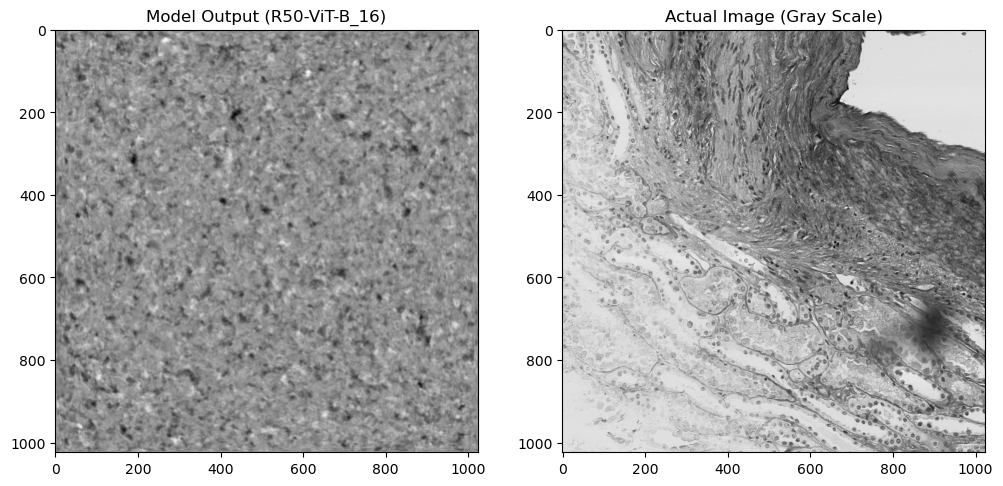

In [137]:
# Set which network to use + set pretrained weight path
VIT_MODEL = 'R50-ViT-B_16'
MODEL_PATH = './models/imagenet21k_R50+ViT-B_16.npz'

output = run_vit_model(
    model_name = VIT_MODEL,
    model_path = MODEL_PATH,
    n_classes = 1,
    n_skip = 1,
    patches_size = 16,
    img_size = IMG_SIZE,
    image = test_block
)

# Plot model output vs actual image
f, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(output, cmap='gray')
axes[0].set_title(f'Model Output ({VIT_MODEL})')
axes[1].imshow(kidney_array[Y_SEEK:Y_SEEK+IMG_SIZE,X_SEEK:X_SEEK+IMG_SIZE], cmap='gray')
axes[1].set_title('Actual Image (Gray Scale)')

### Test running with data used in the paper
The Synapse dataset is found here: [Author's Google Drive Link](https://drive.google.com/drive/folders/1ACJEoTp-uqfFJ73qS3eUObQh52nGuzCd).

To run, extract `Synapse` folder and put it root dir of this repo.

load_pretrained: grid-size from 14 to 32


Text(0.5, 1.0, 'Actual Image (Gray Scale)')

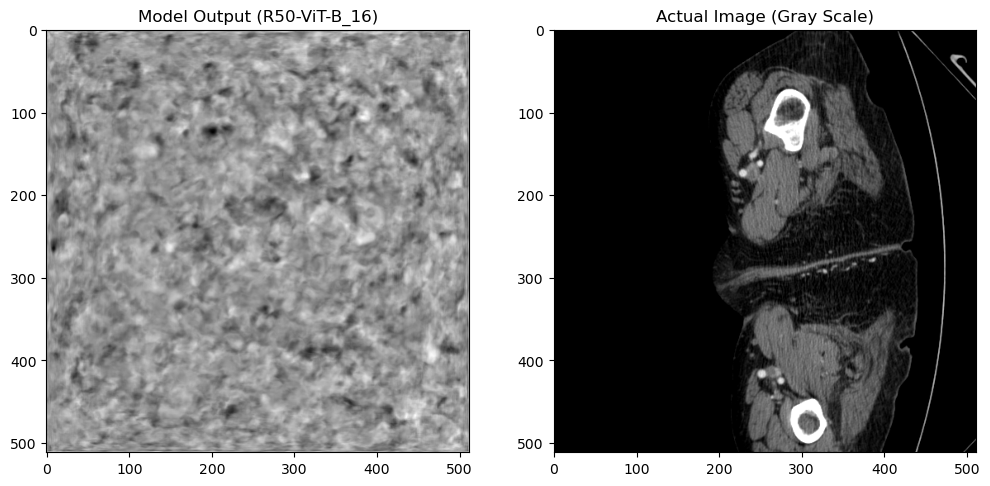

In [138]:
import h5py

# Import Synapse file
h5 = h5py.File('./Synapse/test_vol_h5/case0001.npy.h5','r')

# Convert to tensor
img_tensor = torch.from_numpy(np.asarray([[h5['image'][0]]]))
img_tensor = img_tensor.to(torch.device('cuda'))
img_tensor = img_tensor.type(torch.cuda.FloatTensor)

output = run_vit_model(
    model_name = VIT_MODEL,
    model_path = MODEL_PATH,
    n_classes = 1,
    n_skip = 1,
    patches_size = 16,
    img_size = 512,
    image = img_tensor
)

# Plot model output vs actual image
f, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(output, cmap='gray')
axes[0].set_title(f'Model Output ({VIT_MODEL})')
axes[1].imshow(h5['image'][0], cmap='gray')
axes[1].set_title('Actual Image (Gray Scale)')

Parsing json:   0%|          | 0/160 [00:00<?, ?it/s]

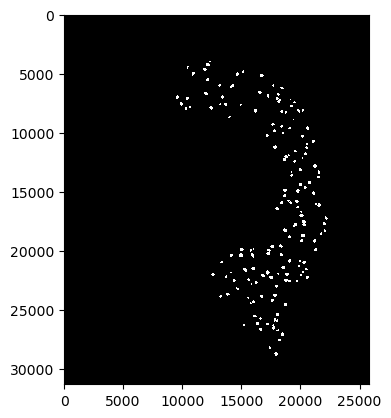

In [181]:
from torch.utils.data import Dataset
import os
import ml_collections
from skimage import draw
from tqdm.auto import tqdm

TRAIN_FOLDER_PATH = '.\\images\\train'

# Generator for getting all the files in a dir with a specific file format
def get_folder_files(folder_dir, target_format):
    target_extension = target_format.strip('.')
    for file_name in os.listdir(folder_dir):
        file_format = file_name.split('.')[-1]
        if target_extension == file_format:
            yield os.path.join(folder_dir, file_name)
            
dataset_config = {
    'patches_size': 512,
    'stride': 512,
    'allow_padding': True
}

dataset_config = ml_collections.ConfigDict(dataset_config)


# Kidney dataset class, store image arrays
# Configurable to get image samples as different patch sizes. Allow for accessing each samples as index
class KidneyImages(Dataset):
    def __init__(self, img_arrays, config):
        super().__init__()
        
        self.config = config
        if not isinstance(img_arrays, np.ndarray):
            self.img_arrays = np.array(img_arrays)
        else:
            self.img_arrays = img_arrays
        
        self.patches_size = config.patches_size
        self.stride = config.stride
        self.allow_padding = config.allow_padding
        
    # Get number of strides possible with the current dataset's patch_size and stride of an array array_len long
    def _get_num_strides(self, array_len):
        if self.allow_padding:
            return int(np.ceil((array_len - self.patches_size) / self.stride)) + 1
        else:
            return int(np.floor((array_len - self.patches_size) / self.stride)) + 1
        
    # Get number of strides possible with the current dataset's patch_size and stride of an image within the dataset
    def _get_img_strides(self, img_id, dim='2d'):
        num_strides_horizontal = self._get_num_strides(self.img_arrays[img_id].shape[1])
        num_strides_vertical = self._get_num_strides(self.img_arrays[img_id].shape[0])
        
        match dim:
            case '2d':
                return num_strides_horizontal * num_strides_vertical
            case 'horizontal':
                return num_strides_horizontal
            case 'vertical':
                return num_strides_vertical
            case _:
                raise ValueError('Unknown dimension config. Please choose from 2d, horizontal, or vertical')
                
    # Return number of sub samples that can be taken with current dataset's patch_size and stride
    def __len__(self):
        total_strides = 0
        for img_id in range(len(self.img_arrays)):
            total_strides += self._get_img_strides(img_id, dim='2d')
        return total_strides
    
    # Return patch from a specific image and patch index within the image
    def _get_patch(self, img_id, idx):
        num_strides_horizontal = self._get_img_strides(img_id, dim='horizontal')
        patch_idx_vertical = idx // num_strides_horizontal * self.stride
        patch_idx_horizontal = idx % num_strides_horizontal * self.stride
        
        img_height = self.img_arrays[img_id].shape[0]
        img_width = self.img_arrays[img_id].shape[1]
        
        if patch_idx_vertical >= img_height or patch_idx_horizontal >= img_width:
            raise IndexError(f'dataset index out of range, dataset length is {self.__len__()}')
        
        if not self.allow_padding:
            return self.img_arrays[img_id][
                patch_idx_vertical:patch_idx_vertical + self.patches_size,
                patch_idx_horizontal:patch_idx_horizontal + self.patches_size
            ]
        else:
            patch = self.img_arrays[img_id][
                patch_idx_vertical:min(img_height, patch_idx_vertical + self.patches_size),
                patch_idx_horizontal:min(img_width, patch_idx_horizontal + self.patches_size)
            ]
            
            pad_height = max(self.patches_size - patch.shape[0], 0)
            pad_width = max(self.patches_size - patch.shape[1], 0)
            
            padded_patch = np.pad(patch, ((0, pad_height), (0, pad_width)), mode='constant')
            
            return padded_patch
    
    # Return path from a patch index
    def __getitem__(self, idx):
        current_idx = idx
        current_img_id = 0
        for img_id in range(len(self.img_arrays)):
            current_num_strides = self._get_img_strides(img_id, dim='2d')
            if current_idx - current_num_strides <= 0:
                current_img_id = img_id
                break
        return self._get_patch(current_img_id, current_idx)

class KidneyLabels(KidneyImages):
    def __init__(self, label_jsons, img_sizes, config):
        super().__init__()
        for label_json in label_jsons:
            binary_mask = _parse_label(label_json, config.target_label)
        self.label_json = label_json
        
        self.config = config
        
    # Parse label_json and returns a 0/1 mask
    def _parse_label(self, label_json, img_size, target_label):
        binary_mask = np.zeros(img_size, dtype=bool)
        pbar = tqdm(total=len(label_json), desc='Parsing json')
        for element in label_json:
            if element['type'] == 'Feature' and element['id'] == 'PathAnnotationObject':
                label = element['geometry']
                if label['type'] == 'Polygon' and element['properties']['classification']['name'] == target_label:
                    coordinates = label['coordinates'][0]
                    image = np.array(draw.polygon2mask(img_size,np.flip(coordinates, axis=None)), dtype=bool)
                    binary_mask |= image
            pbar.update(1)
        plt.imshow(binary_mask, interpolation='nearest', cmap='gray')
        plt.show()

# dataset = KidneyDataset([kidney_array[15000:18000, 15000:18000]], dataset_config)
kidney_label = json.load(open(TEST_LABEL_PATH))
KidneyLabels._parse_label(KidneyLabels, kidney_label, (31278, 25794), 'glomerulus')

Text(0.5, 1.0, 'Model Output (R50-ViT-B_16)')

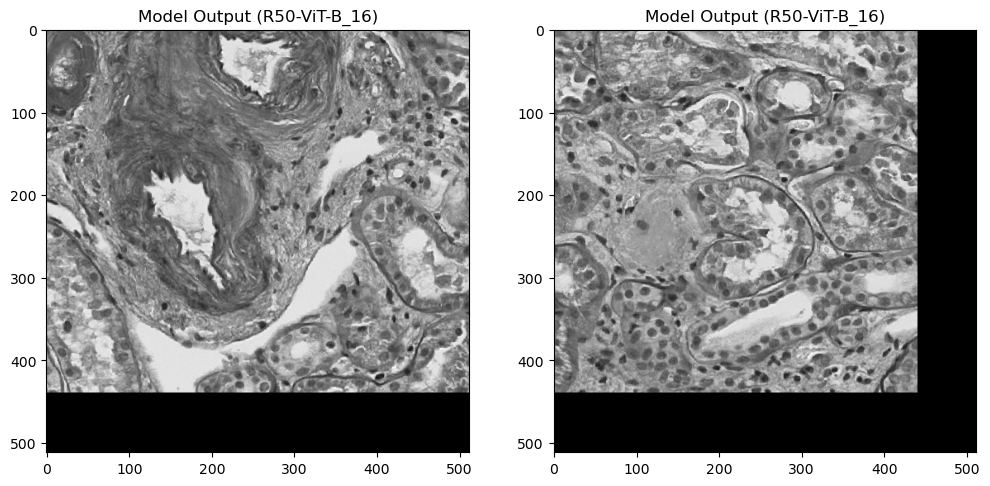

In [156]:

f, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(dataset[34], cmap='gray')
axes[0].set_title(f'Model Output ({VIT_MODEL})')
axes[1].imshow(dataset[35], cmap='gray')
axes[1].set_title(f'Model Output ({VIT_MODEL})')

In [162]:
kidney_array.shape

(31278, 25794)

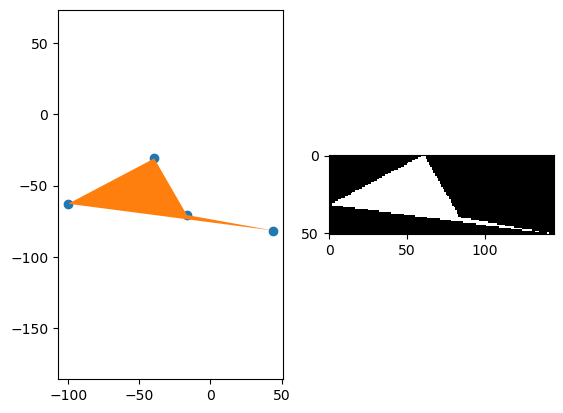

In [166]:
import numpy as np
from skimage import draw

# np.random.seed(1)
# x = np.random.uniform(-100, 100, 4)
# y = np.random.uniform(-100, 100, 4)
# shape = tuple(
#         int(np.ceil(np.ptp(arr)))
#         for arr in [y, x]
#         )
# x_offset = x - np.min(x)
# y_offset = np.max(y) - y
# image = draw.polygon2mask(
#         shape,
#         np.stack((y_offset, x_offset), axis=1)
#         )
fig, ax = plt.subplots(1, 2)
ax[0].scatter(x, y)
ax[0].fill(x, y)
ax[0].axis('equal')

ax[1].imshow(image, interpolation='nearest', cmap='gray')

plt.show()

In [161]:
shape

(51, 145)